In [69]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example 1: Right angle step
Consider a 3-element fault that meets only at right angles, and we impose slip on the node centers.

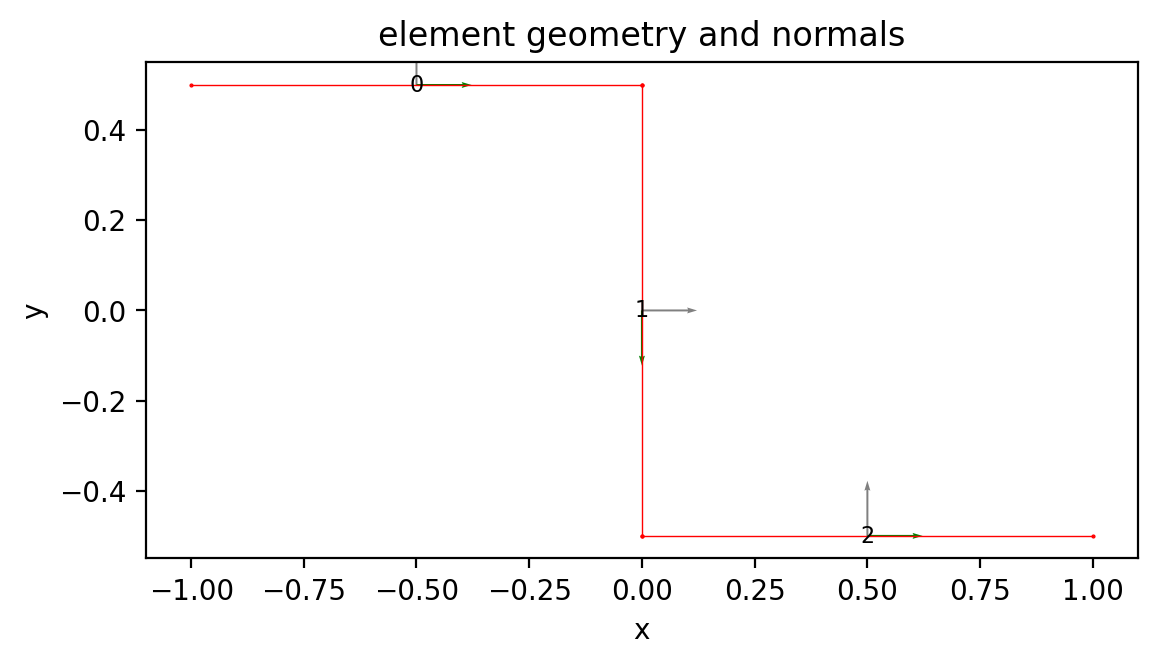

In [70]:
els = bemcs.initialize_els()
els.x1 = np.array([-1.0, 0.0, 0.0])
els.y1 = np.array([0.5, 0.5, -0.5])
els.x2 = np.array([0.0, 0.0, 1.0])
els.y2 = np.array([0.5, -0.5, -0.5])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# dummy = np.vstack((els.x_shears, els.y_shears)).T
# print(dummy)


# Imposed slip (specified in $x,y$ direction)

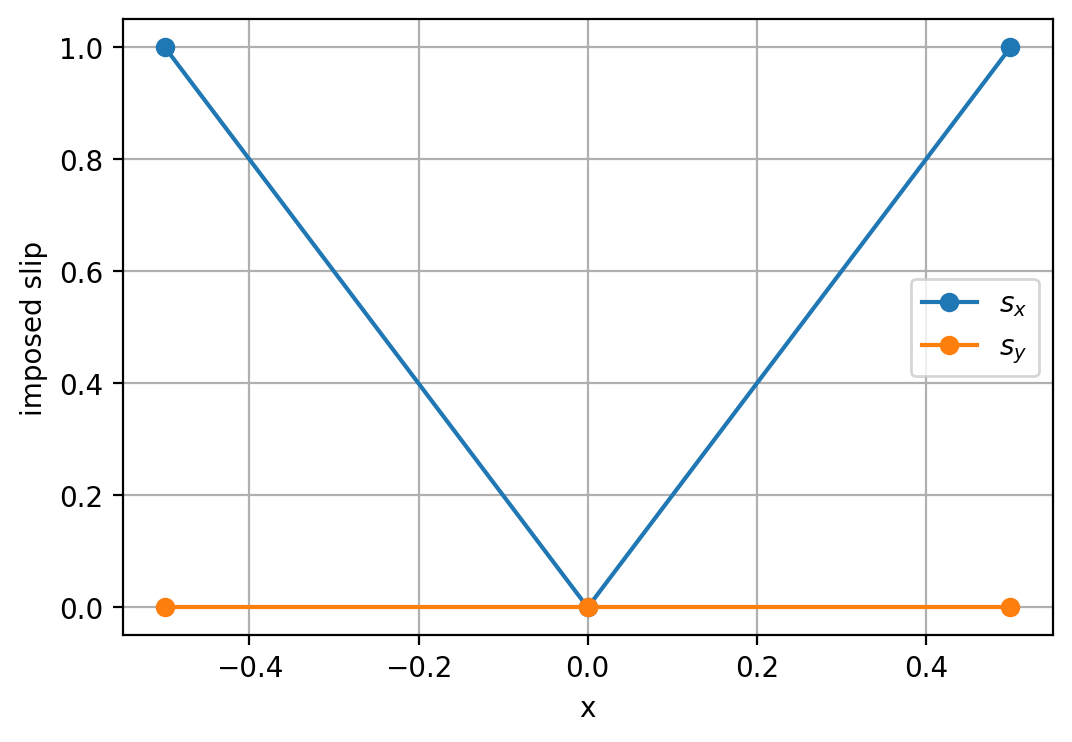

In [71]:
# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array([1.0, 0.0, 1.0])
slip_vector_y = np.array([0.0, 0.0, 0.0])
# slip_vector_x = np.random.rand(3)
# slip_vector_y = np.random.rand(3)

# Plot slip function
plt.figure(figsize=(6, 4))
plt.plot(els.x_centers, slip_vector_x, "o-", label="$s_x$")
plt.plot(els.x_centers, slip_vector_y, "o-", label="$s_y$")
plt.xlabel("x")
plt.ylabel("imposed slip")
plt.grid()
plt.legend()
plt.show()

In [72]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0] = 0.0
bc_vec[1] = 0.0
bc_vec[-1] = 0.0
bc_vec[-2] = 0.0
bc_vec[2::stride] = slip_vector_x
bc_vec[3::stride] = slip_vector_y

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (x component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Compute displacements and stresses 

In [73]:
# Compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25

# Observation coordinates
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width / 2, width / 2, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and normal kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

# Plot displacements and stresses

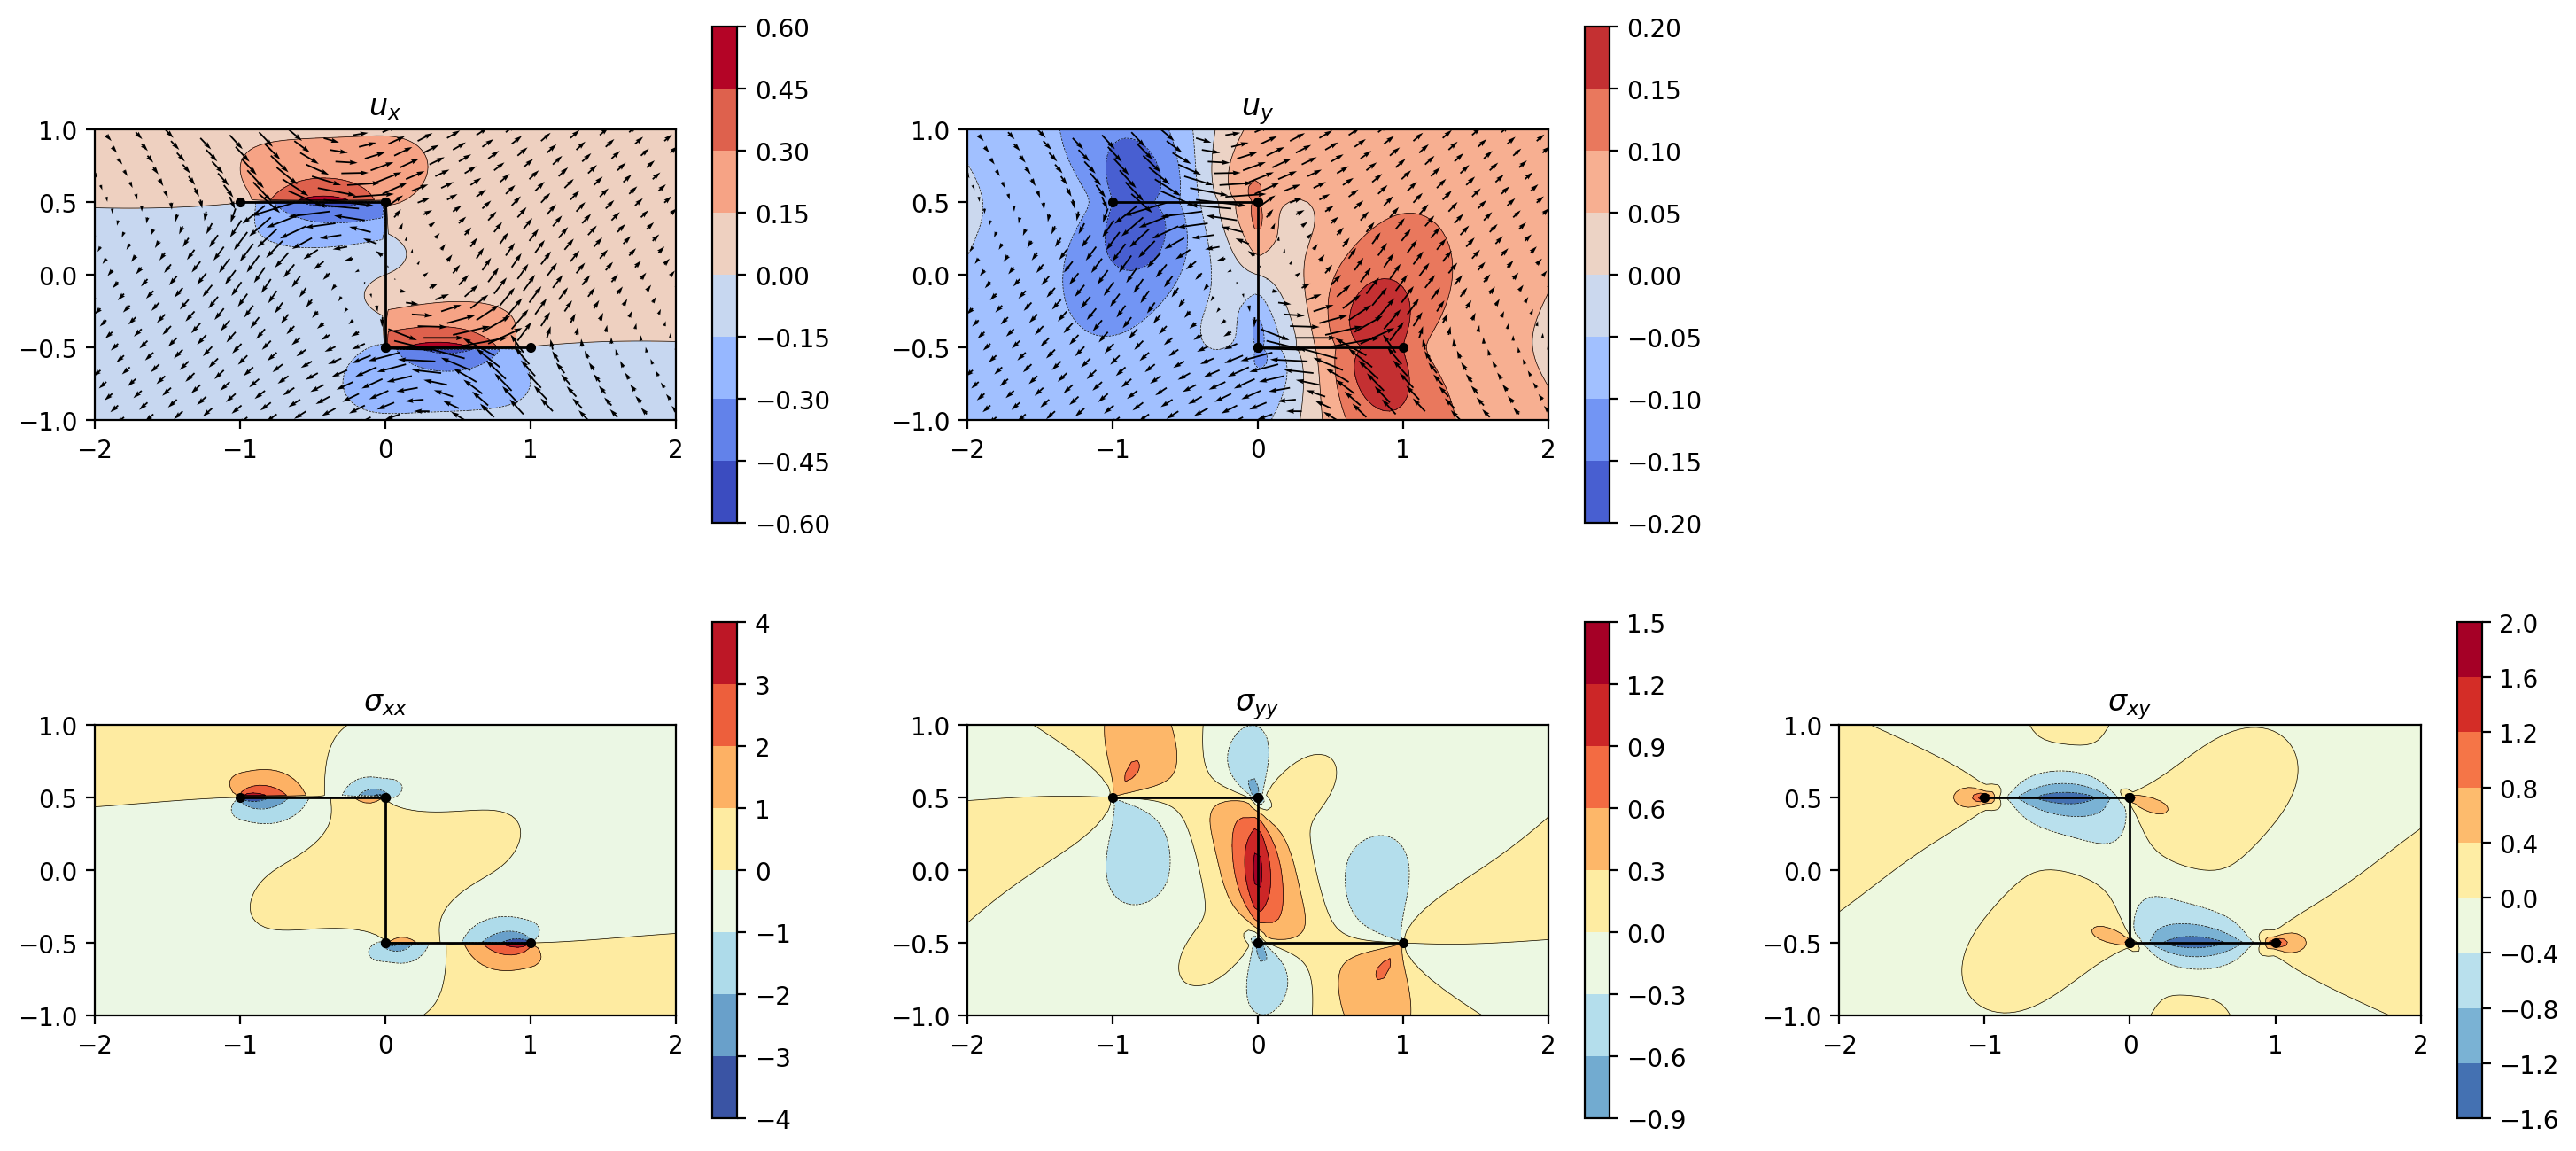

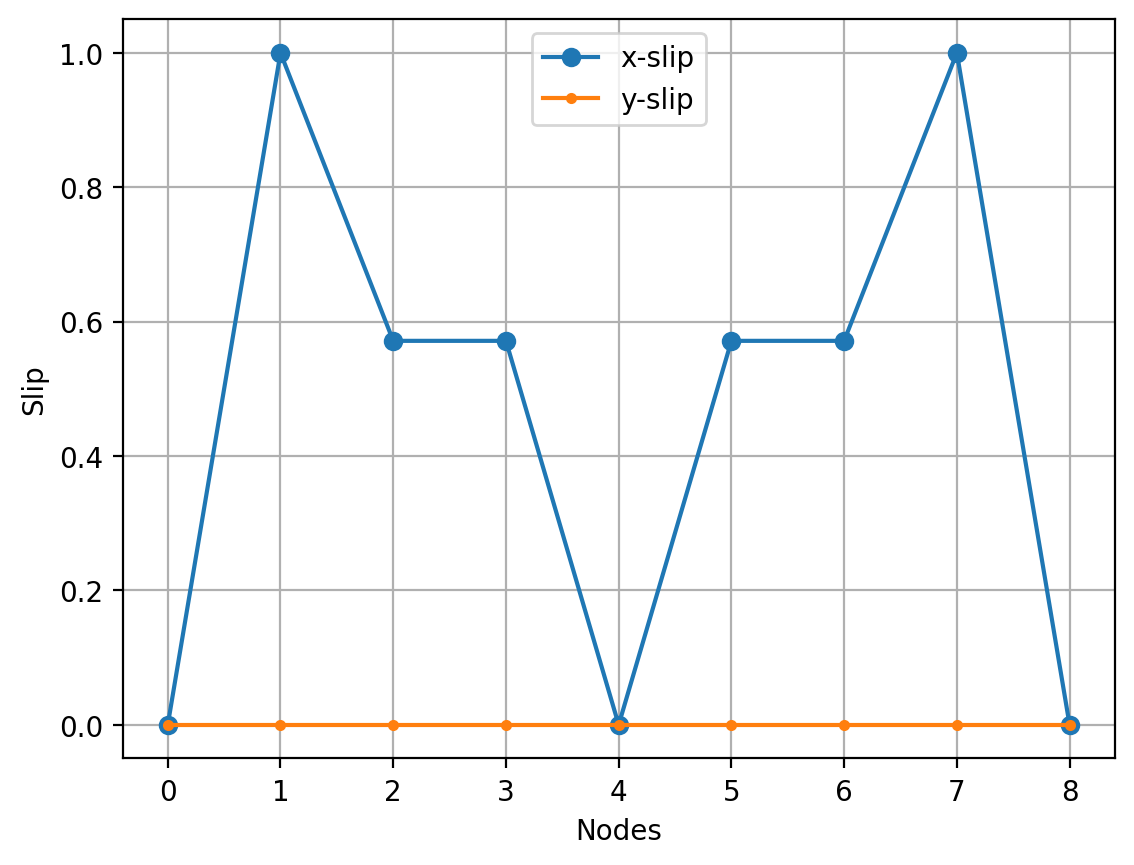

In [74]:
n_skip_plot = 21  # plotting for vectors
bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot
)

# x_nodes = np.zeros((3 * n_els, 1))
# x_nodes[0::3, 0] = els.x1
# x_nodes[2::3, 0] = els.x2
# x_nodes[1::3, 0] = els.x_centers
fault_slip = slip_mat @ coeffs
fault_slip_x = fault_slip[0::2]
fault_slip_y = fault_slip[1::2]
plt.figure()
plt.plot(fault_slip_x, "o-", label="x-slip")
plt.plot(fault_slip_y, ".-", label="y-slip")
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.show()

### Plot tractions along 2 elements

Testing to see if tractions are continuous along the fault

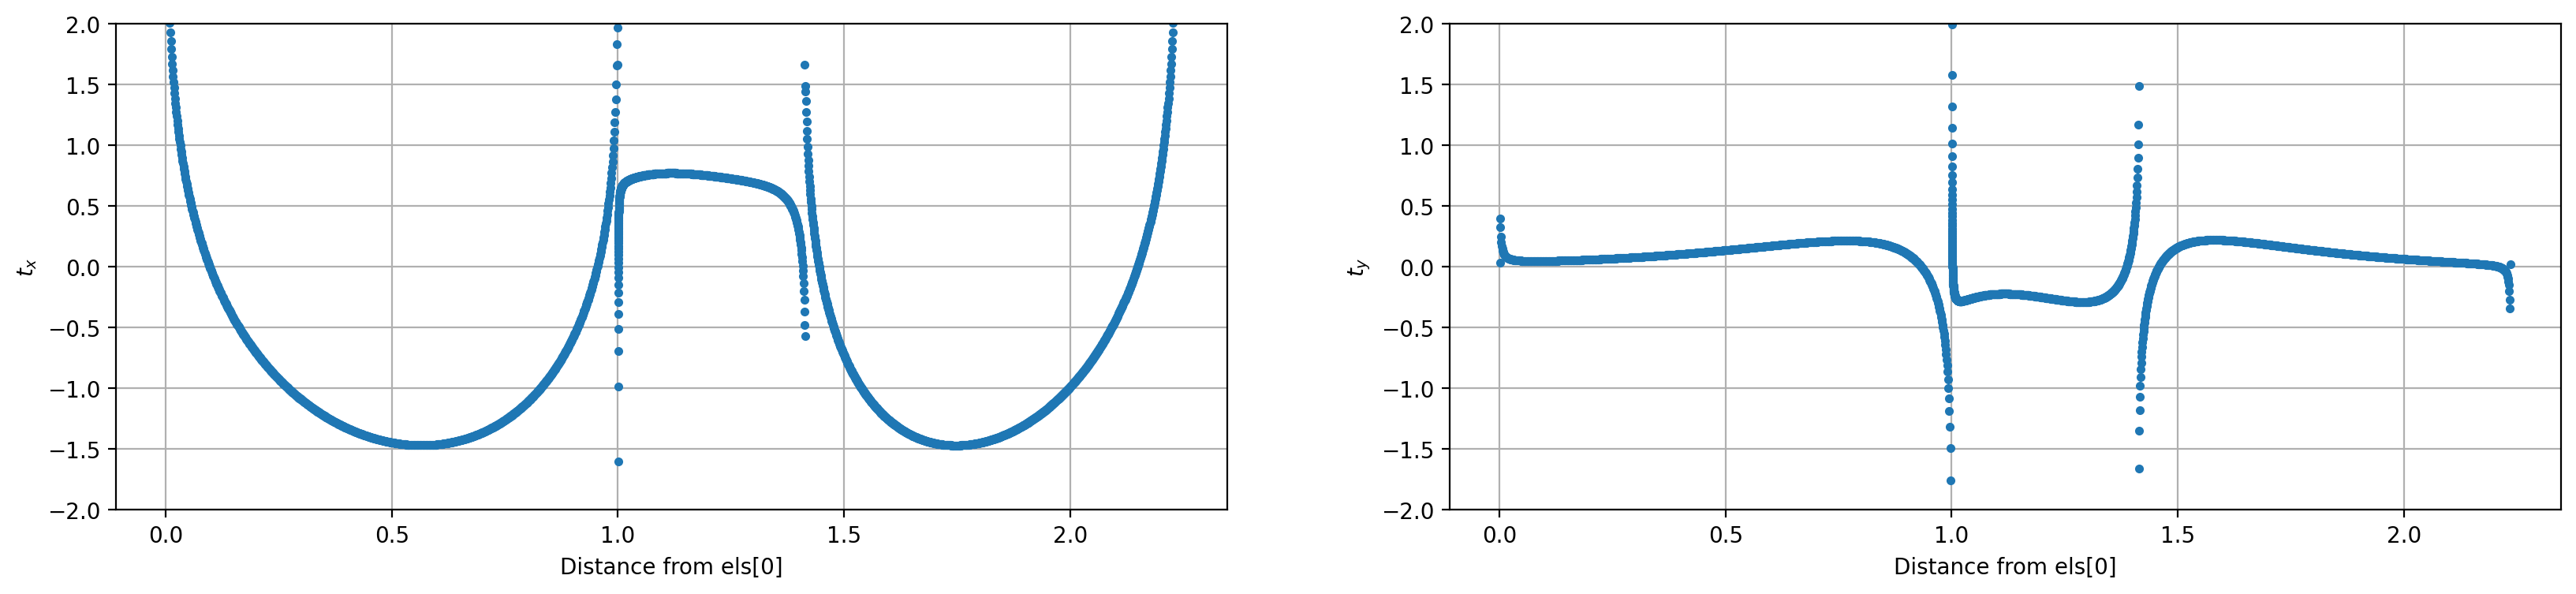

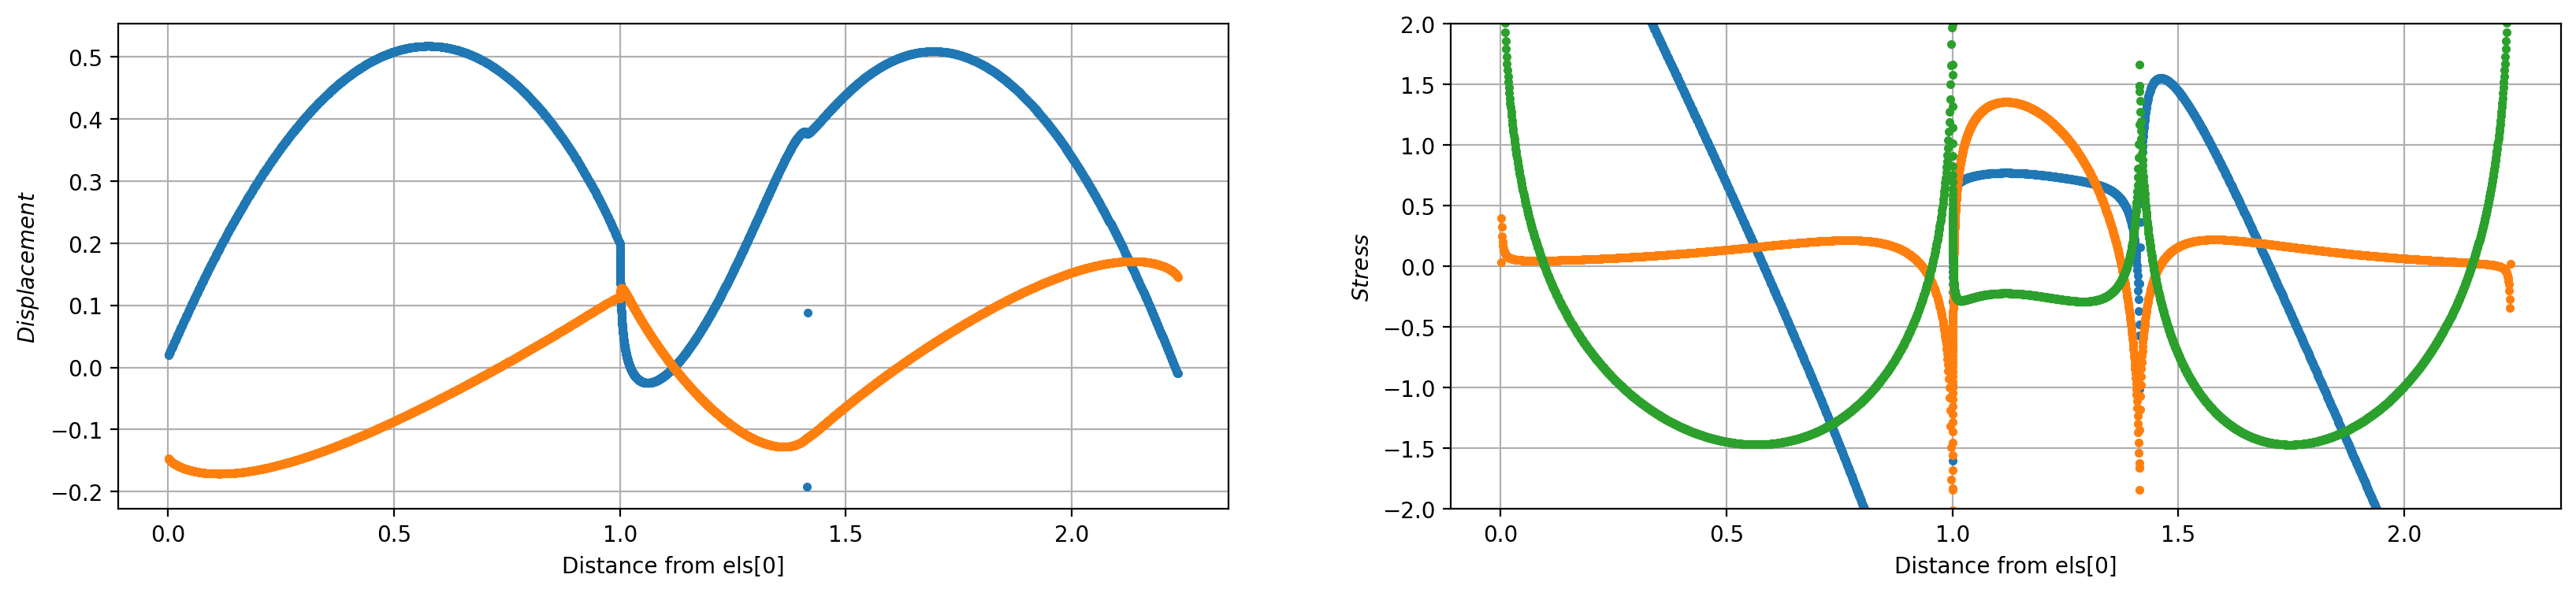

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3000 is different from 9)

In [78]:
# Compute displacements along a line
n_pts = 1000
dr = 1e-3

x_obs = np.hstack(
    (
        np.linspace(els.x1[0], els.x2[0], n_pts) + dr * els.x_normals[0],
        np.linspace(els.x1[1], els.x2[1], n_pts) + dr * els.x_normals[1],
        np.linspace(els.x1[2], els.x2[2], n_pts) + dr * els.x_normals[2],
    )
).reshape(-1, 1)
y_obs = np.hstack(
    (
        np.linspace(els.y1[0], els.y2[0], n_pts) + dr * els.y_normals[0],
        np.linspace(els.y1[1], els.y2[1], n_pts) + dr * els.y_normals[1],
        np.linspace(els.y1[2], els.y2[2], n_pts) + dr * els.y_normals[2],
    )
).reshape(-1, 1)

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)


# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n_pts):
        x_normals = els.x_normals
        y_normals = els.y_normals
        x_shears = els.x_shears
        y_shears = els.y_shears

        self.x_normals = np.zeros(n_pts * len(x_normals))
        self.y_normals = np.zeros(n_pts * len(x_normals))
        self.x_normals[0:n_pts] = x_normals[0]
        self.y_normals[0:n_pts] = y_normals[0]
        self.x_normals[n_pts : 2 * n_pts] = x_normals[1]
        self.y_normals[n_pts : 2 * n_pts] = y_normals[1]
        self.x_normals[2 * n_pts :] = x_normals[2]
        self.y_normals[2 * n_pts :] = y_normals[2]

        self.x_shears = np.zeros(n_pts * len(x_normals))
        self.y_shears = np.zeros(n_pts * len(x_normals))
        self.x_shears[0:n_pts] = x_shears[0]
        self.y_shears[0:n_pts] = y_shears[0]
        self.x_shears[n_pts : 2 * n_pts] = x_shears[1]
        self.y_shears[n_pts : 2 * n_pts] = y_shears[1]
        self.x_shears[2 * n_pts :] = x_shears[2]
        self.y_shears[2 * n_pts :] = y_shears[2]


els_obs = els_normals(els, n_pts)
# print(els.y_normals)
# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# tractions
tx = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n

r = np.sqrt((x_obs - els.x1[0]) ** 2 + (y_obs - els.y1[0]) ** 2)
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(r, tx, ".")
plt.grid()
plt.xlabel("Distance from els[0]")
plt.ylabel("$t_x$")
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.plot(r, ty, ".")
plt.grid()
plt.xlabel("Distance from els[0]")
plt.ylabel("$t_y$")
plt.ylim(-2, 2)
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(r, ux, ".")
plt.plot(r, uy, ".")
plt.grid()
plt.xlabel("Distance from els[0]")
plt.ylabel("$Displacement$")
plt.subplot(1, 2, 2)
plt.plot(r, sxx, ".")
plt.plot(r, syy, ".")
plt.plot(r, sxy, ".")
plt.grid()
plt.ylim(-2, 2)
plt.xlabel("Distance from els[0]")
plt.ylabel("$Stress$")
plt.show()

coeffs_n @ r

# Example 2: Wavy fault

For a sinusoidal fault in an $x,y$ coordinate system, $y = A\sin\left(2n\pi / L\right)$ where $A$ is the amplitude, $n$ is the number of cycles of the sinusoid and $L$ is the fault length in the $x$ dimension. 

In this example we force the slip vector to have purely shear sense slip at the element centers while at the edge nodes continuity and smoothness conditions take over. The resulting slip distribution is rather intriguing! Tensile slip remains 0 at patch centers, as we prescribed, but it is discontinuous and non-zero at overlapping nodes while the slip vector in an $x,y$ coordinate system remains continuous and smooth.

In [ ]:
# flag for slip to be purely shear
slip_purely_shear = True


If you want to test the other option i.e., impose slip in a uniform $x,y$ direction, simply set the variable `slip_purely_shear = False`

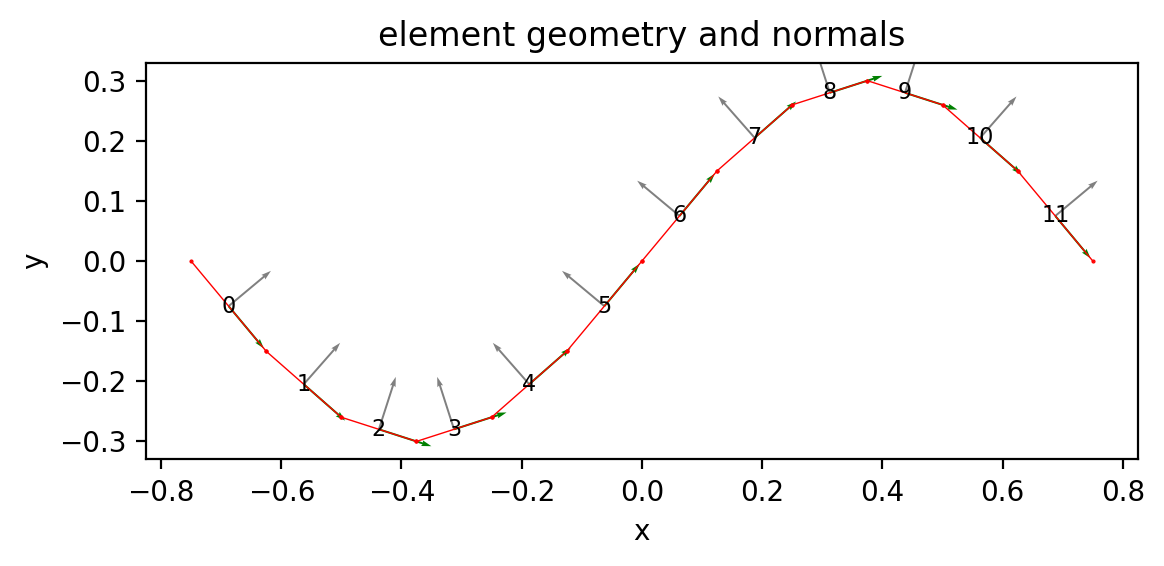

Forcing slip vector at patch centers to be purely shear


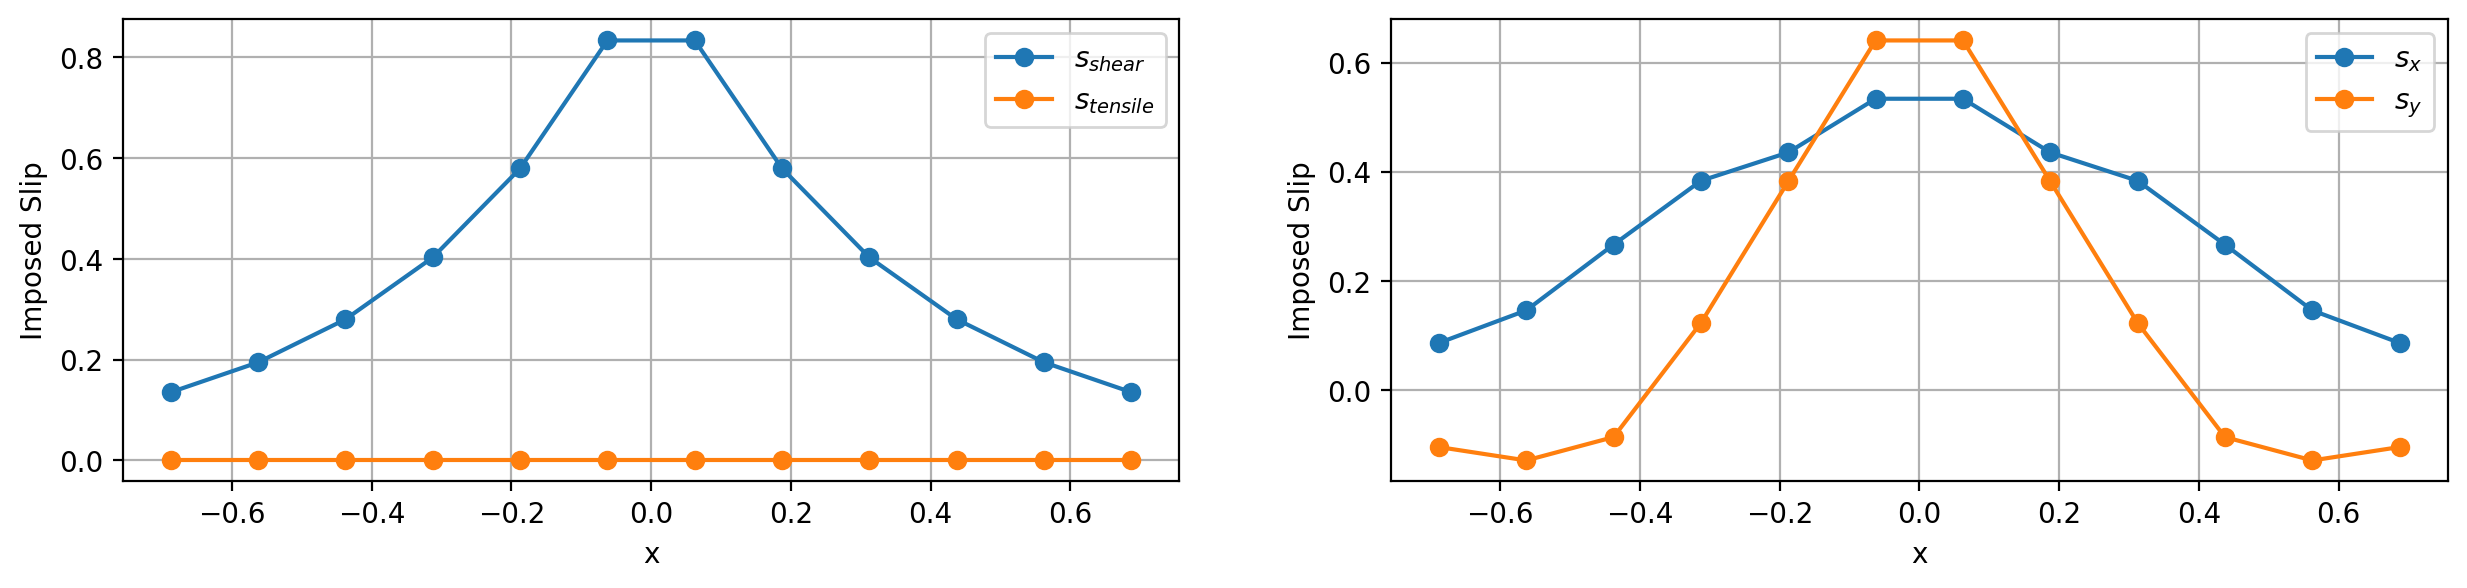

In [ ]:
# Use a non-uniform mesh
n_els = 12
fault_length = 1.5  # fault length in x

# Specify amplitude and number of wavelengths for sinusoidal fault geometry
y_amplitude = 0.3
lambda_cycles = 1.0

# Sinusoidal y-positions for fault elements
sorted_xlocs = np.linspace(
    -fault_length / 2 + fault_length / n_els,
    fault_length / 2 - fault_length / n_els,
    n_els - 1,
)

# Wavy fault geometry
x1 = np.concatenate((np.array([-fault_length / 2.0]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs, np.array([fault_length / 2.0])))
y1 = y_amplitude * np.sin(lambda_cycles * 2 * np.pi * x1 / fault_length)
y2 = y_amplitude * np.sin(lambda_cycles * 2 * np.pi * x2 / fault_length)
els = bemcs.initialize_els()
els.x1 = np.copy(x1)
els.y1 = np.copy(y1)
els.x2 = np.copy(x2)
els.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_values = np.exp(-np.abs(np.linspace(-1, 1, n_els)) / 2 / (0.5**2))
slip_vector_x = np.zeros_like(slip_values)
slip_vector_y = np.zeros_like(slip_values)
slip_vector_s = np.zeros_like(slip_values)
slip_vector_n = np.zeros_like(slip_values)

# Force slip vector to be purely shear (s_n = 0)
if slip_purely_shear == True:
    slip_vector_s = slip_values
    slip_vector_n = np.zeros_like(slip_vector_s)
    slip_vector = np.vstack((slip_vector_s, slip_vector_n)).T
    print("Forcing slip vector at patch centers to be purely shear")
    for i in range(n_els):
        slip_vector_x[i], slip_vector_y[i] = (
            slip_vector[i, :] @ els.rot_mats_inv[i, :, :]
        )
else:
    slip_vector_x = slip_values
    slip_vector_y = np.zeros_like(slip_vector_x)
    slip_vector = np.vstack((slip_vector_x, slip_vector_y)).T
    for i in range(n_els):
        slip_vector_s[i], slip_vector_n[i] = (
            slip_vector[i, :] @ els.rot_mats_inv[i, :, :]
        )

# plot slip function
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot((x1 + x2) / 2, slip_vector_s, "o-", label="$s_{shear}$")
plt.plot((x1 + x2) / 2, slip_vector_n, "o-", label="$s_{tensile}$")
plt.xlabel("x")
plt.ylabel("Imposed Slip")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot((x1 + x2) / 2, slip_vector_x, "o-", label="$s_x$")
plt.plot((x1 + x2) / 2, slip_vector_y, "o-", label="$s_y$")
plt.xlabel("x")
plt.ylabel("Imposed Slip")
plt.grid()
plt.legend()
plt.show()

# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0:2] = 0.0
bc_vec[-2:] = 0.0
bc_vec[2::stride] = slip_vector_x
bc_vec[3::stride] = slip_vector_y

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (x component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Wavy fault displacement, stresses, and slip

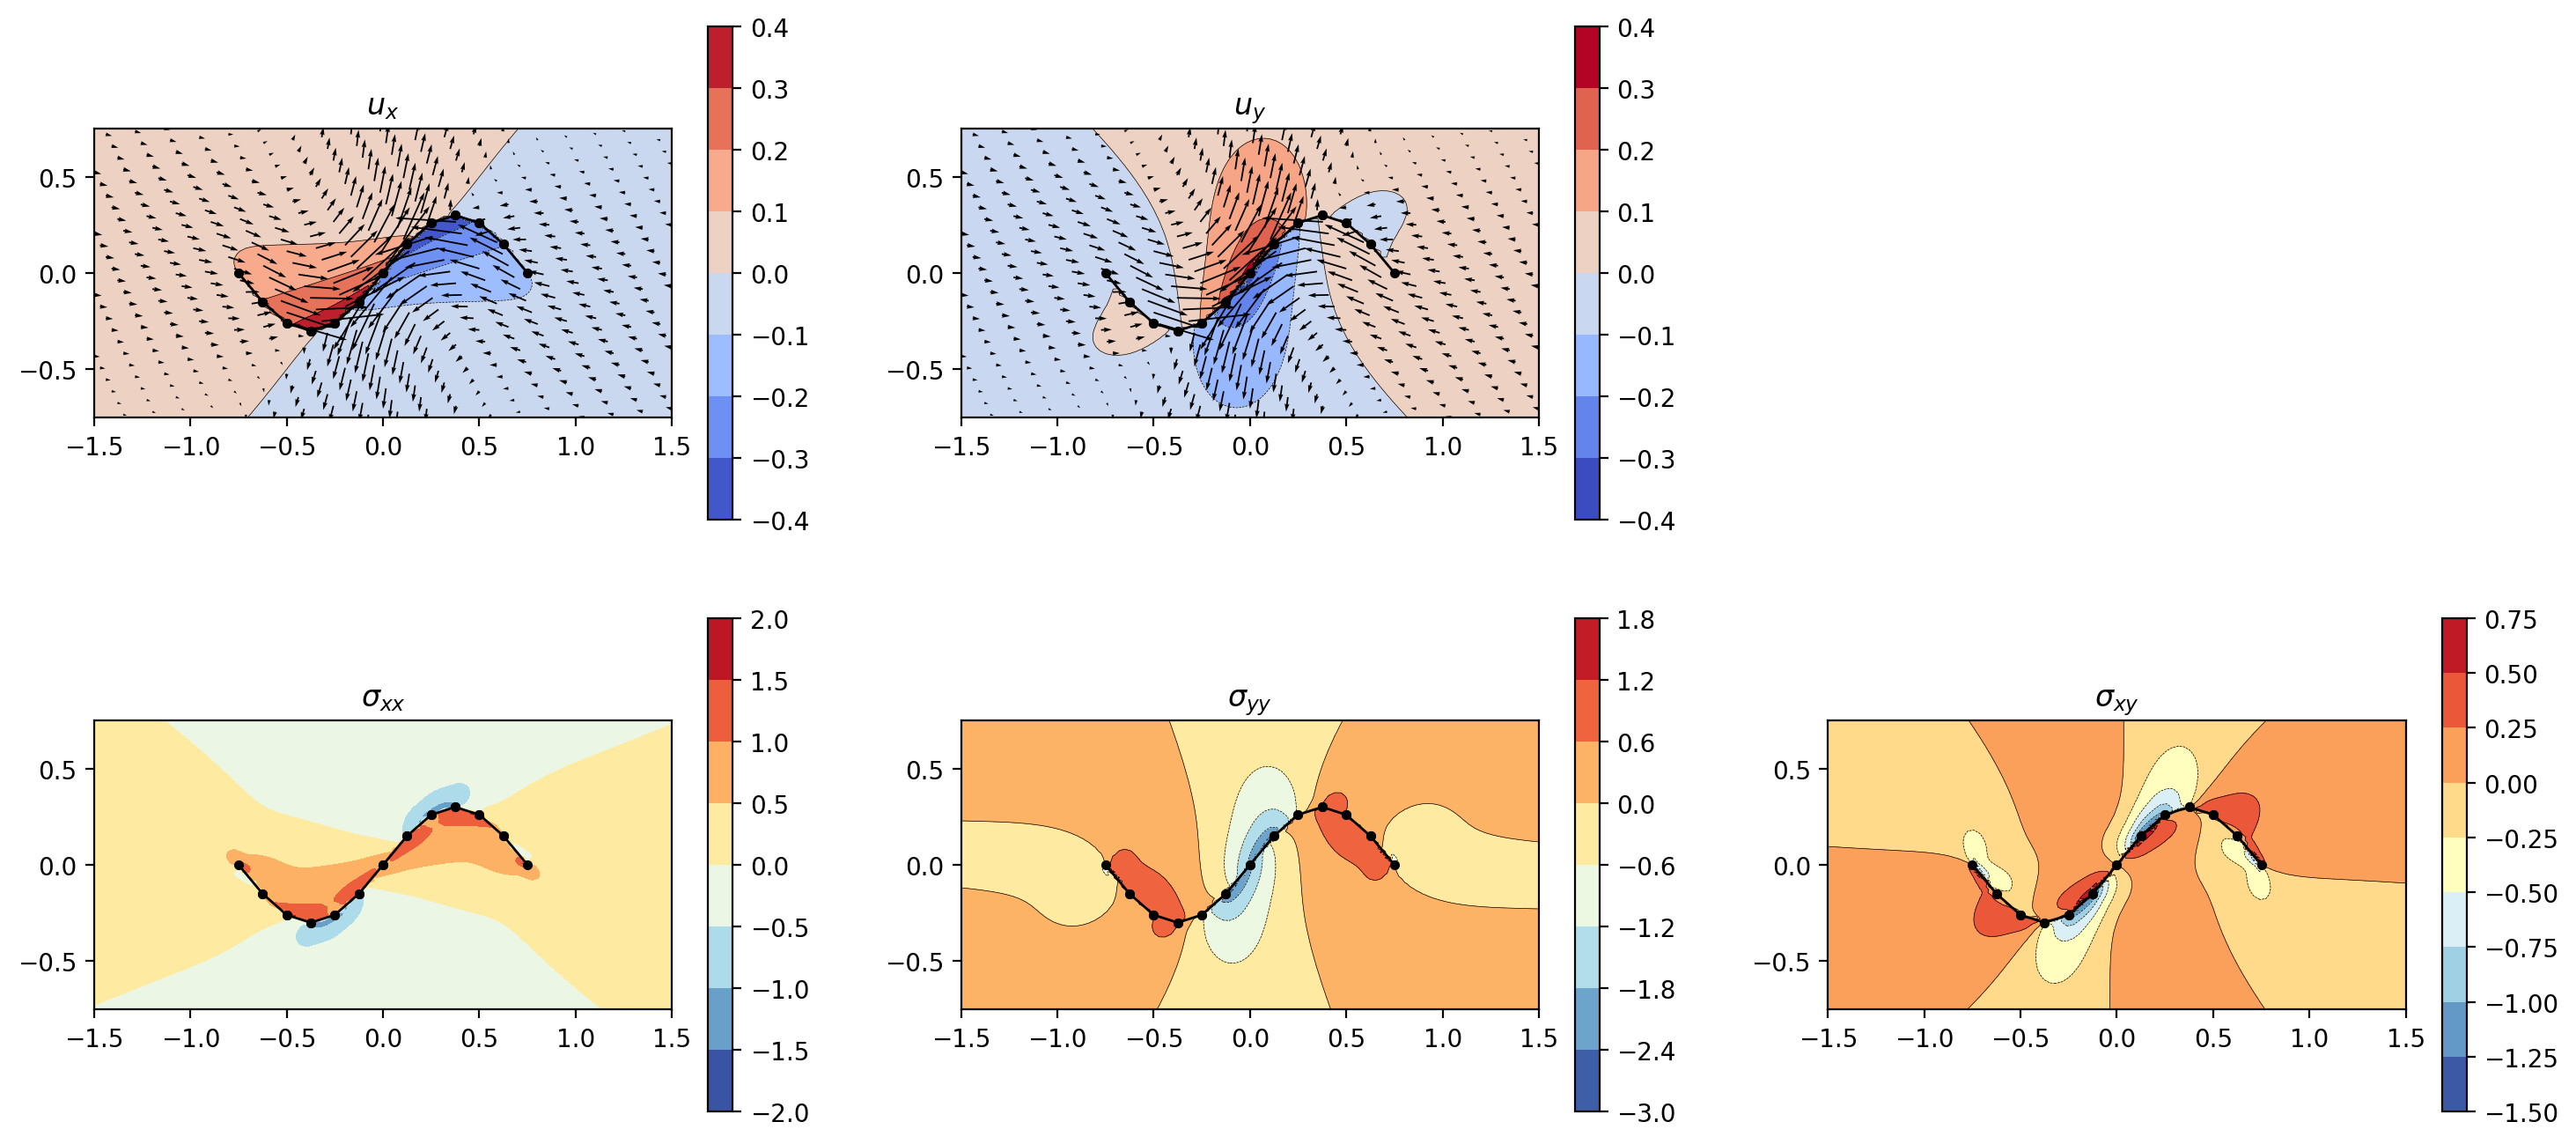

In [ ]:
# Elastic parameters
mu = 1
nu = 0.25
n_obs = 100
width = 1.5
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width / 2, width / 2, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

n_skip_plot = 21  # plotting for vectors
bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot
)

# On fault slip

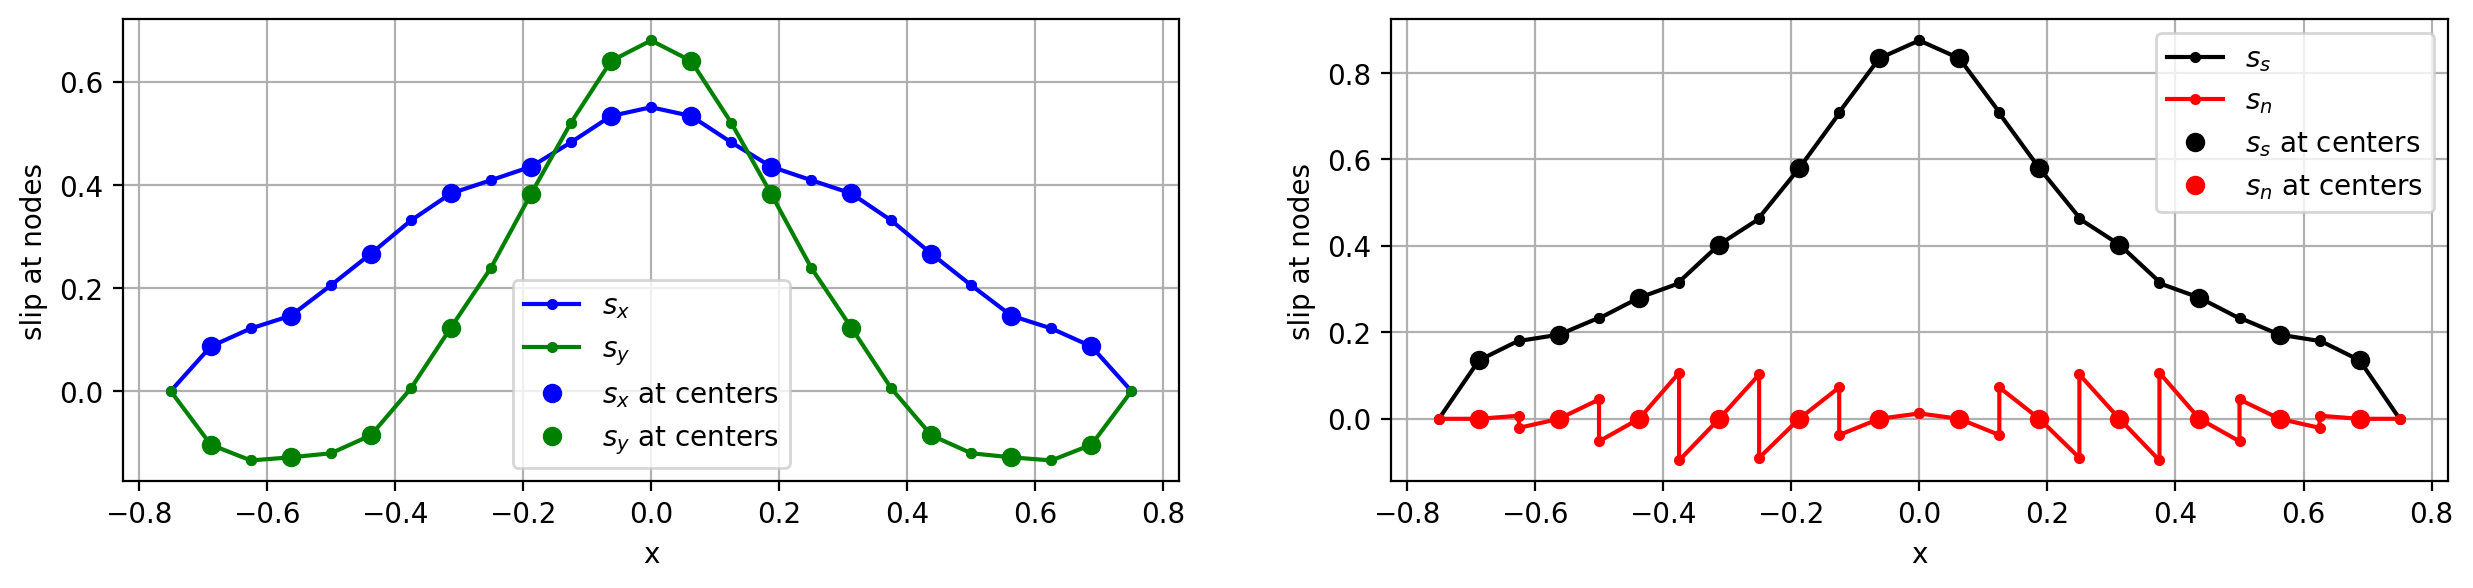

In [ ]:
slip_nodes = slip_mat @ coeffs
slip_nodes = slip_nodes[:, None]
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vec = np.hstack((slip_nodes_x, slip_nodes_y))

# Rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3 * n_els, 1))
slip_nodes_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    temp = slip_vec[3 * i : 3 * (i + 1)] @ els.rot_mats[i, :, :]
    slip_nodes_s[3 * i : 3 * (i + 1), 0] = temp[:, 0]
    slip_nodes_n[3 * i : 3 * (i + 1), 0] = temp[:, 1]

x_nodes = np.zeros((3 * n_els, 1))
x_nodes[0::3, 0] = els.x1
x_nodes[2::3, 0] = els.x2
x_nodes[1::3, 0] = els.x_centers

plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(x_nodes, slip_nodes_x, "b.-", label="$s_x$")
plt.plot(x_nodes, slip_nodes_y, "g.-", label="$s_y$")
plt.plot(x_nodes[1:-1:3, 0], slip_nodes_x[1:-1:3, 0], "bo", label="$s_x$ at centers")
plt.plot(x_nodes[1:-1:3, 0], slip_nodes_y[1:-1:3, 0], "go", label="$s_y$ at centers")
plt.xlabel("x")
plt.ylabel("slip at nodes")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_nodes, slip_nodes_s, "k.-", label="$s_s$")
plt.plot(x_nodes, slip_nodes_n, "r.-", label="$s_n$")
plt.plot(x_nodes[1:-1:3, 0], slip_nodes_s[1:-1:3, 0], "ko", label="$s_s$ at centers")
plt.plot(x_nodes[1:-1:3, 0], slip_nodes_n[1:-1:3, 0], "ro", label="$s_n$ at centers")
plt.xlabel("x")
plt.ylabel("slip at nodes")
plt.legend()
plt.grid()
plt.show()